In [27]:
!pip install plotly

In [28]:
import pandas as pd

bookings = pd.read_csv('./bookings.csv')

### Fix typings

In [29]:
bookings['number_of_reviews'] = bookings['number_of_reviews'].str.replace(',', '', regex=True)
bookings['number_of_reviews'] = pd.to_numeric(bookings['number_of_reviews'], errors='coerce')
bookings['review_score'] = pd.to_numeric(bookings['review_score'], errors='coerce')
bookings['original_price'] = pd.to_numeric(bookings['original_price'], errors='coerce')
bookings['discounted_price'] = pd.to_numeric(bookings['discounted_price'], errors='coerce')

### Reviews Distribution
Group the review counts by snapshot dates, and the names of the hotels. the `number_of_reviews` will be a the same for the same hotel in a certain snapshot.   

In [30]:
number_of_reviews = bookings.groupby(['name', 'snapshot_date'], as_index=False)['number_of_reviews'].first()
number_of_reviews

,name,snapshot_date,number_of_reviews
0,1 Hotel Central Park,2025-02-02,556.0
1,1 Hotel Central Park,2025-02-03,556.0
2,17John,2025-02-02,209.0
3,17John,2025-02-03,209.0
4,2 Bedroom Cozy Central Apartment,2025-02-02,8.0
...,...,...,...
711,citizenM New York Times Square,2025-02-03,3999.0
712,"voco The Franklin New York, an IHG Hotel",2025-02-02,508.0
713,"voco The Franklin New York, an IHG Hotel",2025-02-03,508.0
714,"voco Times Square South New York, an IHG Hotel",2025-02-02,3803.0


In [31]:
snapshot_dates = bookings['snapshot_date'].unique()

In [32]:
import plotly.graph_objects as go

fig = go.Figure()

for date in snapshot_dates:
    data = number_of_reviews[number_of_reviews['snapshot_date'] == date]['number_of_reviews'].dropna()
    fig.add_trace(go.Histogram(x=data, name=str(date), opacity=0.5, autobinx=True))

# Update layout for better visualization
fig.update_layout(
    title= "Distribution of Number of Reviews for Each Snapshot Date",
    xaxis_title="Number of Reviews",
    yaxis_title="Frequency",
    barmode="overlay",  # Makes histograms overlap
    legend_title="Snapshot Date",
    width=1400,  # Increase figure width
    height=800   # Increase figure height
)

# Show interactive plot
fig.show()

In [33]:
# Drop NaN values from 'review_score'

import plotly.express as px

review_scores = bookings.groupby(['name', 'snapshot_date'], as_index=False)['review_score'].first()

# Create subplots for each snapshot date
fig = go.Figure()

for date in snapshot_dates:
    data = review_scores[review_scores['snapshot_date'] == date]['review_score'].dropna()
    fig.add_trace(go.Histogram(x=data, name=str(date), opacity=0.5, bingroup=100))

# Update layout to separate the graphs
fig.update_layout(
    title="Distribution of Review Scores for Each Snapshot Date",
    xaxis_title="Review Score",
    yaxis_title="Frequency",
    barmode='overlay',  # Ensures histograms are separate
    legend_title="Snapshot Date",
    width=1000,
    height=600
)

# Show interactive plot
fig.show()

In [34]:
price_data = bookings.groupby(['name', 'snapshot_date'], as_index=False)[['original_price', 'discounted_price']].first()

# Get unique snapshot dates
snapshot_dates = price_data['snapshot_date'].unique()

# Create subplots for each snapshot date
fig = go.Figure()

for date in snapshot_dates:
    snapshot_prices = price_data[price_data['snapshot_date'] == date]
    
    fig.add_trace(go.Histogram(
        x=snapshot_prices['original_price'].dropna(),
        name=f"Original Price - {date}",
        opacity=0.5
    ))
    
    fig.add_trace(go.Histogram(
        x=snapshot_prices['discounted_price'].dropna(),
        name=f"Discounted Price - {date}",
        opacity=0.3
    ))

# Update layout for better visualization
fig.update_layout(
    title="Distribution of Original and Discounted Prices for Each Snapshot Date",
    xaxis_title="Price",
    yaxis_title="Frequency",
    barmode='overlay',  # Ensures histograms overlap for comparison
    legend_title="Snapshot Date & Price Type",
    width=1000,
    height=600
)

# Show the interactive plot
fig.show()

The prices shown in the graph above do not account for the length of stay. The graph below displays the distribution of "price per night."

In [35]:
bookings['discounted_price_per_night'] = bookings['discounted_price'] / bookings['length_of_stay']
bookings['original_price_per_night'] = bookings['original_price'] / bookings['length_of_stay']

price_per_night_data = bookings.groupby(['name', 'snapshot_date'], as_index=False)[['original_price_per_night', 'discounted_price_per_night']].first()

# Get unique snapshot dates
snapshot_dates = price_per_night_data['snapshot_date'].unique()

# Create subplots for each snapshot date
fig = go.Figure()

for date in snapshot_dates:
    snapshot_prices = price_per_night_data[price_per_night_data['snapshot_date'] == date]
    
    fig.add_trace(go.Histogram(
        x=snapshot_prices['original_price_per_night'].dropna(),
        name=f"Original Price per night - {date}",
        opacity=0.5
    ))
    
    fig.add_trace(go.Histogram(
        x=snapshot_prices['discounted_price_per_night'].dropna(),
        name=f"Discounted Price per night - {date}",
        opacity=0.3
    ))

# Update layout for better visualization
fig.update_layout(
    title="Distribution of Original and Discounted Prices per night for Each Snapshot Date",
    xaxis_title="Price per night",
    yaxis_title="Frequency",
    barmode='overlay',  # Ensures histograms overlap for comparison
    legend_title="Snapshot Date & Price Type",
    width=1000,
    height=600
)

# Show the interactive plot
fig.show()

### Filter outliers by price and price_per_night data

In [ ]:
import plotly.express as px

# Create a box plot (hbox) for original and discounted price per night
fig = px.box(
    price_per_night_data.melt(id_vars=['snapshot_date'], value_vars=['original_price_per_night', 'discounted_price_per_night'], 
                              var_name="Price Type", value_name="Price per Night"),
    x="snapshot_date",
    y="Price per Night",
    color="Price Type",
    title="Box Plot of Original and Discounted Prices per Night for Each Snapshot Date",
    labels={"snapshot_date": "Snapshot Date", "Price per Night": "Price per Night"},
    width=1000,
    height=600
)

# Show the interactive box plot
fig.show()

In [69]:
import plotly.express as px

# Create a box plot (hbox) for original and discounted price per night
fig = px.box(
    price_data.melt(id_vars=['snapshot_date'], value_vars=['original_price', 'discounted_price'], 
                              var_name="Price Type", value_name="Price"),
    x="snapshot_date",
    y="Price",
    color="Price Type",
    title="Box Plot of Original and Discounted Prices for Each Snapshot Date",
    labels={"snapshot_date": "Snapshot Date", "Price": "Price"},
    width=1000,
    height=600
)

# Show the interactive box plot
fig.show()

In [104]:
# Remove price outliers using Tukey's IQR method
new_bookings = bookings.copy()
Q1 = new_bookings["original_price_per_night"].quantile(0.25)
Q3 = new_bookings["original_price_per_night"].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter the dataset
new_bookings = new_bookings[(new_bookings["original_price_per_night"] >= lower_bound) & (new_bookings["original_price_per_night"] <= upper_bound)]

# Drop bookings without review title
new_bookings = new_bookings.dropna(subset=['review_title'])

# Display the number of rows after filtering
print(f"Rows after filtering: {len(new_bookings)}, Rows before filtering: {len(bookings)}")

Rows after filtering: 29104, Rows before filtering: 29998


In [105]:
new_bookings['review_title'].unique()

array(['Very good', 'Good', 'Fabulous', 'Review score', 'Superb',
       'Exceptional'], dtype=object)

In [106]:
# Define ordinal mappings for review titles
review_title_mapping = {
    'Review score': 1,   # Lowest
    'Good': 2,
    'Very good': 3,
    'Fabulous': 4,
    'Superb': 5,
    'Exceptional': 6    # Highest
}

# Apply the mapping to review_title column
new_bookings["review_title_rank"] = new_bookings["review_title"].map(review_title_mapping)

In [107]:
# Extract unique bed types
unique_beds = bookings["bed_type"].dropna().unique()
unique_beds

array(['1 large double bed', '1 extra-large double bed', '1 double bed',
       '1 single bed', '2 single beds', '2 double beds',
       '2 large double beds', 'Multiple bed types', '1 bunk bed',
       'Private suite', '3 beds (2 doubles, 1 sofa bed)',
       '2 beds (1 extra-large double, 1 sofa bed)',
       '2 extra-large double beds', '2 beds (1 bunk bed, 1 large double)',
       '2 bunk beds', '2 beds (1 double, 1 sofa bed)',
       '5 beds (3 extra-large doubles, 2 large doubles)',
       '2 beds (1 single, 1 extra-large double)', '3 single beds',
       '2 beds (1 single, 1 large double)', '2 beds (1 single, 1 double)',
       'Beds: 1 double or 2 singles',
       '2 beds (1 sofa bed, 1 large double)',
       '4 beds (1 double, 1 bunk bed, 1 sofa bed, 1 large double)',
       '3 beds (1 bunk bed, 2 large doubles)'], dtype=object)

In [108]:
# Example ranking for bed types (adjust as needed)
bed_type_mapping = {
    'Multiple bed types': 1,  # Vague and lacks specifics
    '1 single bed': 2,  # Least valuable, smallest sleeping arrangement
    '1 bunk bed': 3,  # Compact but only good for certain situations
    '1 double bed': 4,  # Standard, but smaller than a large double
    '1 large double bed': 5,  # Comfortable for two
    '1 extra-large double bed': 6,  # Large and luxurious for two
    '2 single beds': 7,  # Simple twin setup, less desirable than a double
    '2 bunk beds': 8,  # Sleeps four but is less comfortable
    '3 single beds': 9,  # Good for separate sleepers but lacks bed size variety
    '2 beds (1 single, 1 double)': 10,  # One double and one single, still decent
    '2 beds (1 single, 1 large double)': 11,  # One large and one single, slightly less valuable than extra-large
    '2 beds (1 single, 1 extra-large double)': 12,  # One very large and one small bed
    '2 beds (1 bunk bed, 1 large double)': 13,  # One solid large bed + bunk bed for kids
    '2 beds (1 sofa bed, 1 large double)': 14,  # Large double + extra seating/bed
    '2 beds (1 double, 1 sofa bed)': 15,  # Standard double bed + sofa, good for a couple + 1
    '2 beds (1 extra-large double, 1 sofa bed)': 16,  # Large main bed + extra sofa sleeper
    'Beds: 1 double or 2 singles': 17,  # Flexibility makes this valuable
    '2 double beds': 18,  # Standard two-bed setup, good for small families/groups
    '2 large double beds': 19,  # Large but slightly less spacious than extra-large beds
    '2 extra-large double beds': 20,  # Luxury and spacious for up to four people
    '3 beds (2 doubles, 1 sofa bed)': 21,  # Two doubles + a sofa bed is a flexible setup
    '3 beds (1 bunk bed, 2 large doubles)': 22,  # Large family/group-friendly
    '4 beds (1 double, 1 bunk bed, 1 sofa bed, 1 large double)': 23,  # Great for a mix of sleepers
    '5 beds (3 extra-large doubles, 2 large doubles)': 24,  # Accommodates large groups comfortably
    'Private suite': 25  # Typically premium, offering the best experience
}

# Apply bed type ranking
new_bookings["bed_type_rank"] = new_bookings["bed_type"].map(bed_type_mapping)

# Show a preview of the transformed columns
new_bookings[["review_title", "review_title_rank", "bed_type", "bed_type_rank"]].head()

,review_title,review_title_rank,bed_type,bed_type_rank
0,Very good,3,1 large double bed,5.0
1,Good,2,1 extra-large double bed,6.0
2,Fabulous,4,1 double bed,4.0
3,Good,2,1 single bed,2.0
4,Good,2,1 extra-large double bed,6.0


In [109]:
new_bookings['neighborhood'].unique()

array(['Manhattan, New York', "Hell's Kitchen, New York",
       'Upper West Side, New York', 'Chelsea, New York',
       'Lower East Side, New York', 'SoHo, New York',
       'Midtown East, New York', 'Tribeca, New York',
       'Gramercy, New York', 'Murray Hill, New York',
       'Chinatown, New York', 'Upper East Side, New York',
       'NoMad, New York', 'Flatiron District, New York',
       'Washington Heights, New York', 'Little Italy, New York',
       'Kips Bay, New York', 'Harlem, New York', 'New York',
       'Greenwich Village, New York', 'Hudson Yards, New York',
       'Union Square, New York', 'East Village, New York',
       'Battery Park, New York', 'East Harlem, New York'], dtype=object)

In [114]:
from sklearn.preprocessing import OneHotEncoder
import pandas as pd

# Initialize OneHotEncoder
encoder = OneHotEncoder(drop="first", sparse_output=False)  

# Fit and transform the data
encoded_data = encoder.fit_transform(new_bookings[["neighborhood"]])
encoded_data

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], shape=(29104, 24))

one hot encoded neighborhood dataframe:

In [119]:
encoded_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out(['neighborhood']))
encoded_df.columns = [col.replace("neighborhood_", "").replace(", New York", "").strip() for col in encoded_df.columns]

encoded_df

,Chelsea,Chinatown,East Harlem,East Village,Flatiron District,Gramercy,Greenwich Village,Harlem,Hell's Kitchen,Hudson Yards,...,Midtown East,Murray Hill,New York,NoMad,SoHo,Tribeca,Union Square,Upper East Side,Upper West Side,Washington Heights
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29099,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
29100,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
29101,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
29102,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Combine the dataframes

In [120]:
encoded_df = encoded_df.reset_index(drop=True)
new_bookings = new_bookings.reset_index(drop=True)

# Concatenate along columns
new_bookings = pd.concat([new_bookings, encoded_df], axis=1)
new_bookings

,Unnamed: 0,name,original_price,discounted_price,discount,review_score,review_title,number_of_reviews,star_rating,is_apartment,...,Midtown East,Murray Hill,New York,NoMad,SoHo,Tribeca,Union Square,Upper East Side,Upper West Side,Washington Heights
0,0,Iroquois New York Times Square,292,218,True,8.5,Very good,2625.0,5.0,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,Four Points by Sheraton New York Downtown,130,111,True,7.8,Good,1987.0,3.0,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,"The Mayfair Hotel Times Square, Ascend Hotel C...",141,141,False,8.6,Fabulous,1895.0,3.0,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,The Washington by LuxUrban,160,160,False,7.7,Good,9442.0,4.0,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,Hampton Inn by Hilton New York Times Square,152,152,False,7.8,Good,2432.0,3.0,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29099,29993,Sheraton New York Times Square Hotel,1429,1429,False,6.4,Review score,1795.0,4.0,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
29100,29994,Wingate by Wyndham New York Midtown South/5th Ave,1222,1222,False,8.4,Very good,2384.0,3.0,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
29101,29995,Hotel AKA NoMad,1802,1693,True,8.3,Very good,663.0,4.0,False,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
29102,29996,"InterContinental New York Times Square, an IHG...",1587,1587,False,7.9,Good,1787.0,4.0,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


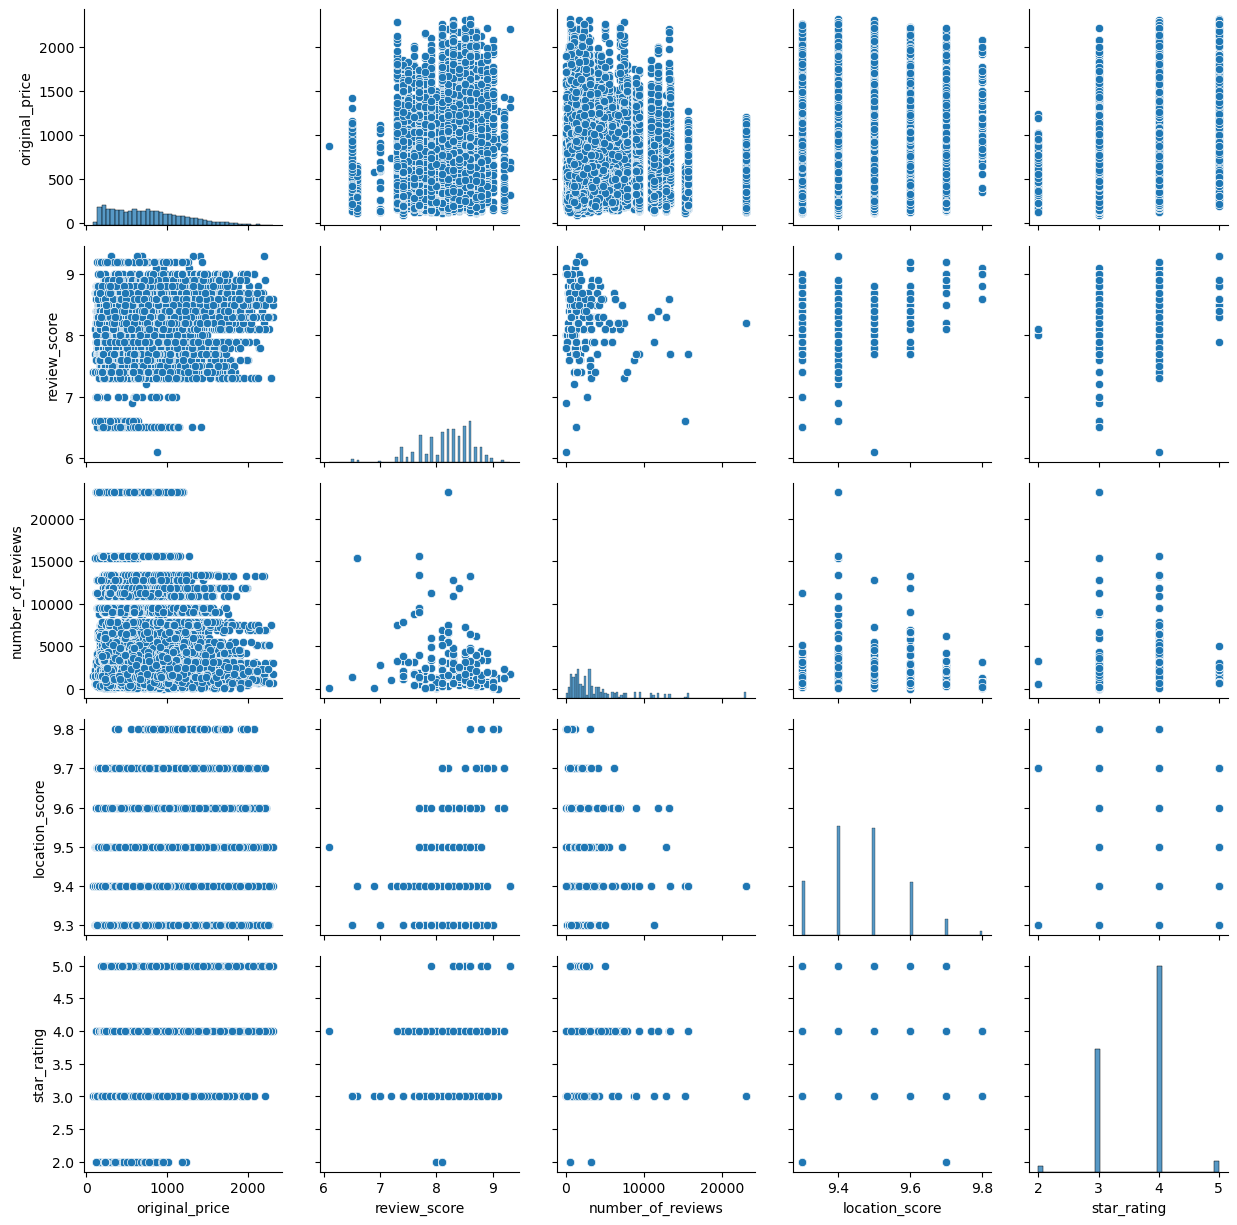

In [121]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select numerical variables for PairGrid
selected_columns = ["original_price", "review_score", "number_of_reviews", "location_score", "star_rating"]
pairgrid_df = new_bookings[selected_columns].dropna()  # Drop NaN values for plotting

# Create PairGrid
g = sns.PairGrid(pairgrid_df)
g.map_diag(sns.histplot)  # Histograms on the diagonal
g.map_offdiag(sns.scatterplot)  # Scatter plots on off-diagonal

# Show the plot
plt.show()

In [122]:
new_bookings.to_csv('./proccessed_bookings.csv')